pip install geopandas

In [734]:
pip install geopandas

Note: you may need to restart the kernel to use updated packages.


In [735]:
pip install plotly

Note: you may need to restart the kernel to use updated packages.


This time series analysis hopes to find a coorelation between accident location, type of issue, time taken to resolve issue, time of day, day of week, and month of year. This will help predict when and where an accident is likely to happen.

# Import necessary libraries

In [736]:
import pandas as pd
import numpy as np
import datetime
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import t
import scipy.stats as ss
from numpy.random import seed

import descartes
import geopandas as gpd
from shapely.geometry import Point, Polygon

%matplotlib inline


# Data Collection/Organization

In [737]:
file = 'Data/traffic_data_cleaned.csv'


In [738]:
df = pd.read_csv(file)
df.head()


,short_ID,published_date,issue_reported,Latitude,Longitude,Address,status_date,issue_timespan,published_day,timespan_sec,timespan_min,time
0,C16,2018-06-13 06:35:59+00:00,Crash Service,30.283797,-97.741906,W 21ST ST & GUADALUPE ST,2018-06-13 09:00:03+00:00,0 days 02:24:04,2,8644.0,144.066667,06:35:59
1,6B2,2018-06-13 10:15:36+00:00,Traffic Hazard,30.339593,-97.700963,400-717 E ANDERSON LN EB,2018-06-13 11:20:03+00:00,0 days 01:04:27,2,3867.0,64.450000,10:15:36
2,2A7,2020-04-17 21:25:03+00:00,Crash Urgent,30.329455,-97.638105,E US 290 HWY SVRD EB & EASTERN HEIGHTS BLVD,2020-04-17 21:55:03+00:00,0 days 00:30:00,4,1800.0,30.000000,21:25:03
3,89D,2020-04-17 21:40:52+00:00,Traffic Hazard,30.202806,-97.760701,5300-blk S Ih 35 Sb,2020-04-17 21:55:03+00:00,0 days 00:14:11,4,851.0,14.183333,21:40:52
4,E7F,2020-04-17 21:00:55+00:00,Crash Urgent,30.184265,-97.687339,4500-4720 S Us 183 Hwy Sb,2020-04-17 23:30:04+00:00,0 days 02:29:09,4,8949.0,149.150000,21:00:55


In [739]:
df.shape

(225445, 12)

There are 225,445 rows and 12 columns

In [740]:
df.describe()

,Latitude,Longitude,published_day,timespan_sec,timespan_min
count,225445.000000,225445.000000,225445.000000,225445.000000,225445.000000
mean,30.301440,-97.733156,2.906261,2979.937018,49.665617
std,0.094080,0.087511,1.935056,2381.053573,39.684226
min,30.003883,-98.226709,0.000000,20.000000,0.333333
25%,30.231715,-97.777183,1.000000,1170.000000,19.500000
50%,30.293602,-97.734450,3.000000,2250.000000,37.500000
75%,30.373691,-97.686922,5.000000,4111.000000,68.516667
max,30.798642,-97.293320,6.000000,12000.000000,200.000000


In [741]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 225445 entries, 0 to 225444
Data columns (total 12 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   short_ID        225445 non-null  object 
 1   published_date  225445 non-null  object 
 2   issue_reported  225445 non-null  object 
 3   Latitude        225445 non-null  float64
 4   Longitude       225445 non-null  float64
 5   Address         225445 non-null  object 
 6   status_date     225445 non-null  object 
 7   issue_timespan  225445 non-null  object 
 8   published_day   225445 non-null  int64  
 9   timespan_sec    225445 non-null  float64
 10  timespan_min    225445 non-null  float64
 11  time            225445 non-null  object 
dtypes: float64(4), int64(1), object(7)
memory usage: 20.6+ MB


In [733]:
df['time'] = df['time'].replace(':','')
df['time'] = pd.to_numeric(df['time'], errors = 'coerce')
df.head()

,short_ID,published_date,issue_reported,Latitude,Longitude,Address,status_date,issue_timespan,published_day,timespan_sec,timespan_min,time
0,C16,2018-06-13 06:35:59+00:00,Crash Service,30.283797,-97.741906,W 21ST ST & GUADALUPE ST,2018-06-13 09:00:03+00:00,0 days 02:24:04,2,8644.0,144.066667,NaN
1,6B2,2018-06-13 10:15:36+00:00,Traffic Hazard,30.339593,-97.700963,400-717 E ANDERSON LN EB,2018-06-13 11:20:03+00:00,0 days 01:04:27,2,3867.0,64.450000,NaN
2,2A7,2020-04-17 21:25:03+00:00,Crash Urgent,30.329455,-97.638105,E US 290 HWY SVRD EB & EASTERN HEIGHTS BLVD,2020-04-17 21:55:03+00:00,0 days 00:30:00,4,1800.0,30.000000,NaN
3,89D,2020-04-17 21:40:52+00:00,Traffic Hazard,30.202806,-97.760701,5300-blk S Ih 35 Sb,2020-04-17 21:55:03+00:00,0 days 00:14:11,4,851.0,14.183333,NaN
4,E7F,2020-04-17 21:00:55+00:00,Crash Urgent,30.184265,-97.687339,4500-4720 S Us 183 Hwy Sb,2020-04-17 23:30:04+00:00,0 days 02:29:09,4,8949.0,149.150000,NaN


# Exploratory Data Analysis

In [722]:
df.issue_reported.unique()

array(['Crash Service', 'Traffic Hazard', 'Crash Urgent',
       'TRFC HAZD/ DEBRIS', 'COLLISION WITH INJURY', 'zSTALLED VEHICLE',
       'COLLISION', 'COLLISN/ LVNG SCN', 'LOOSE LIVESTOCK',
       'Stalled Vehicle', 'BLOCKED DRIV/ HWY',
       'COLLISION/PRIVATE PROPERTY', 'VEHICLE FIRE', 'Traffic Impediment'],
      dtype=object)

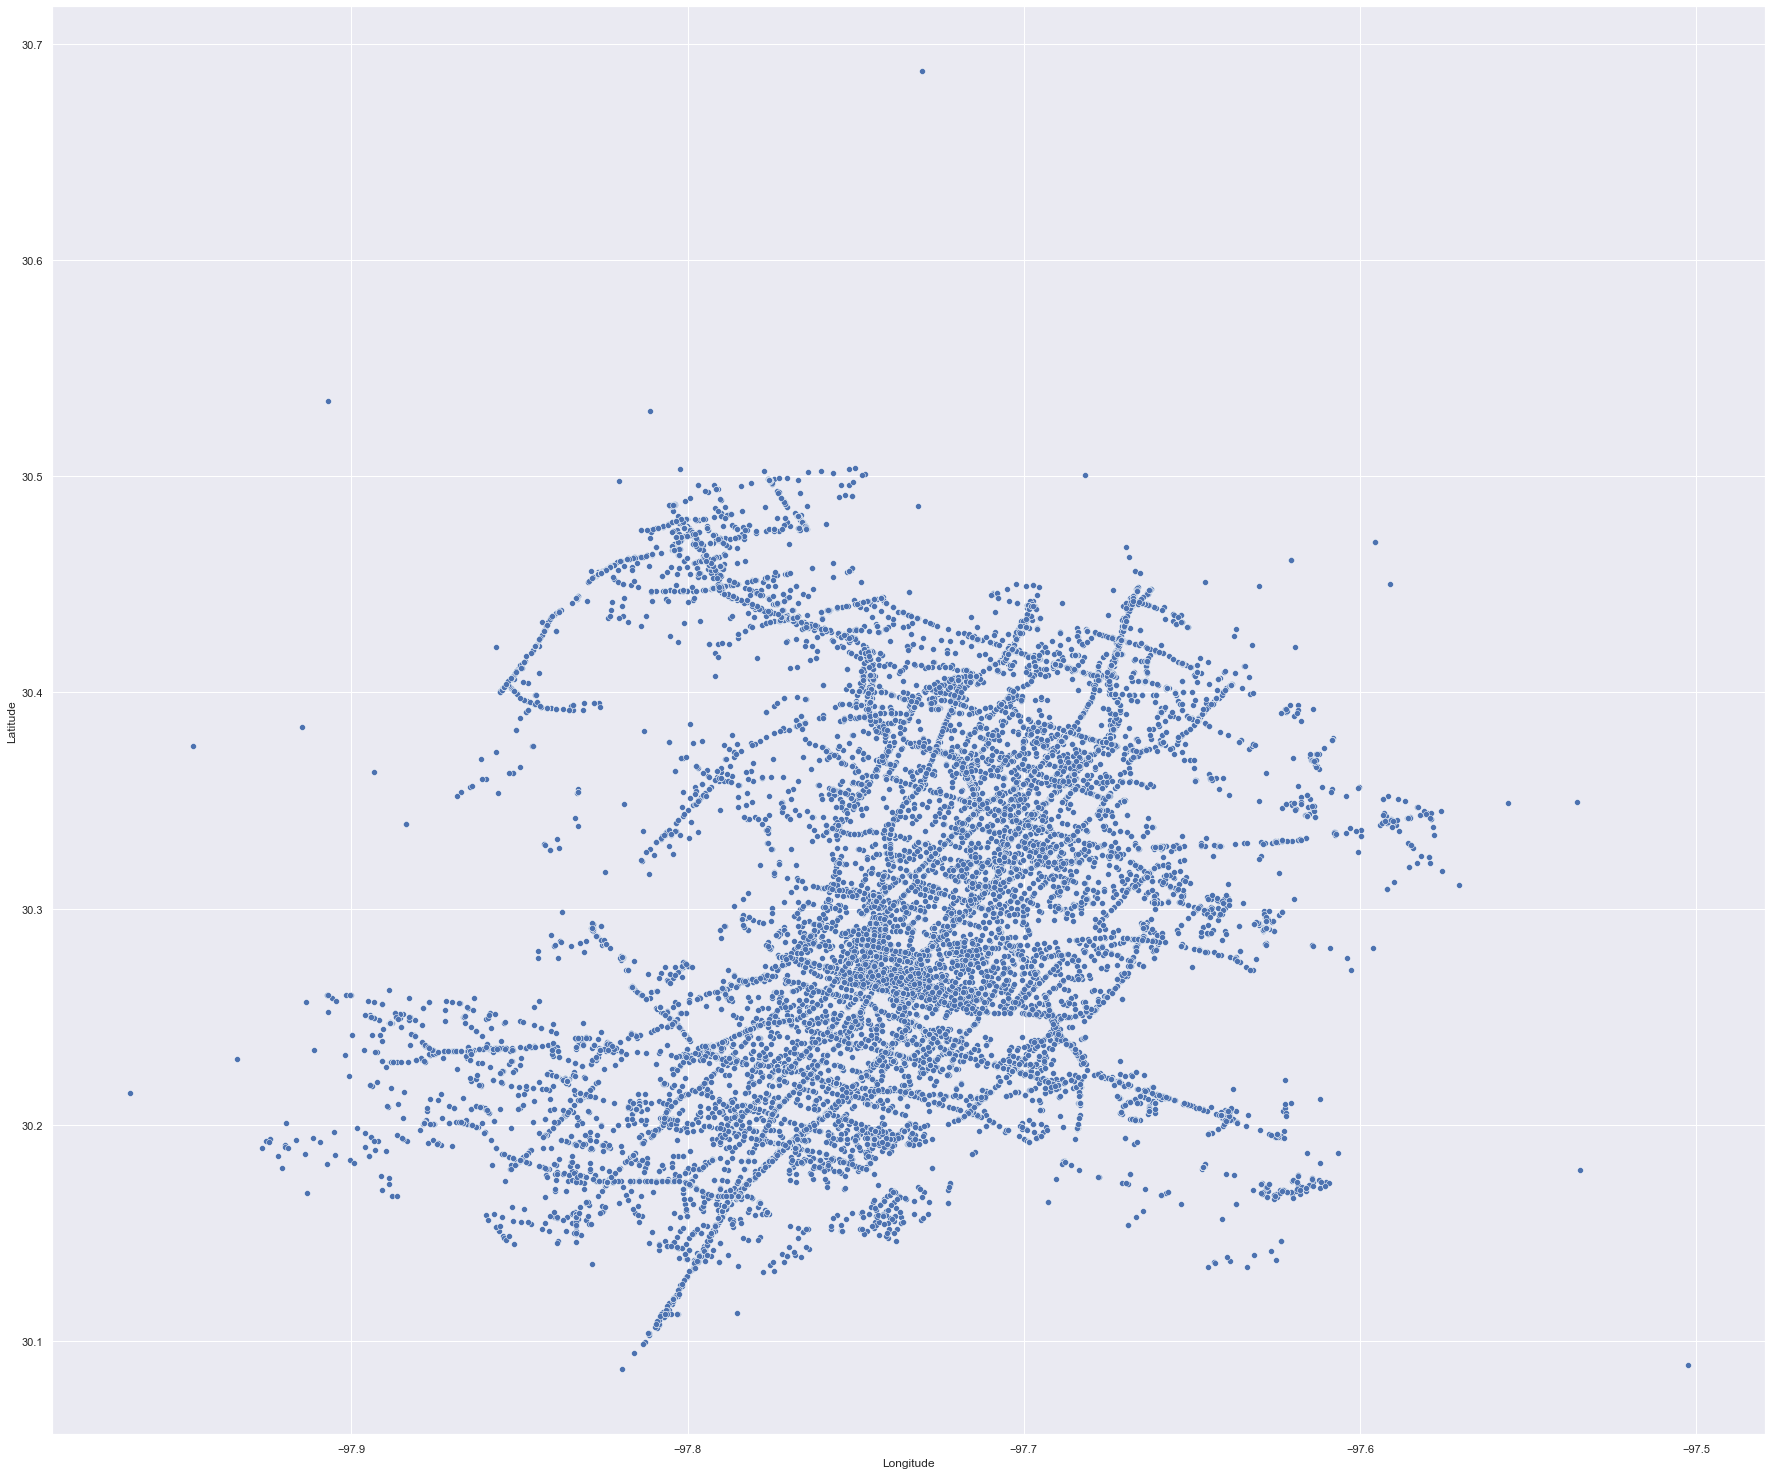

In [723]:
sns.scatterplot(x='Longitude',y='Latitude', data= df[df.issue_reported == 'Crash Service'])
sns.set(rc={'figure.figsize':(30.7,26.27)})

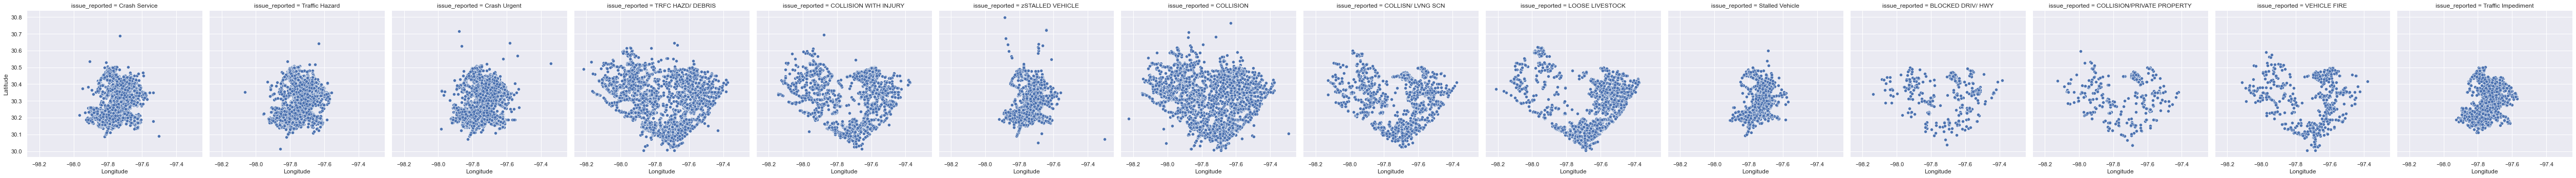

In [724]:
ax = sns.relplot(x='Longitude',y='Latitude', data=df, kind='scatter', col='issue_reported')

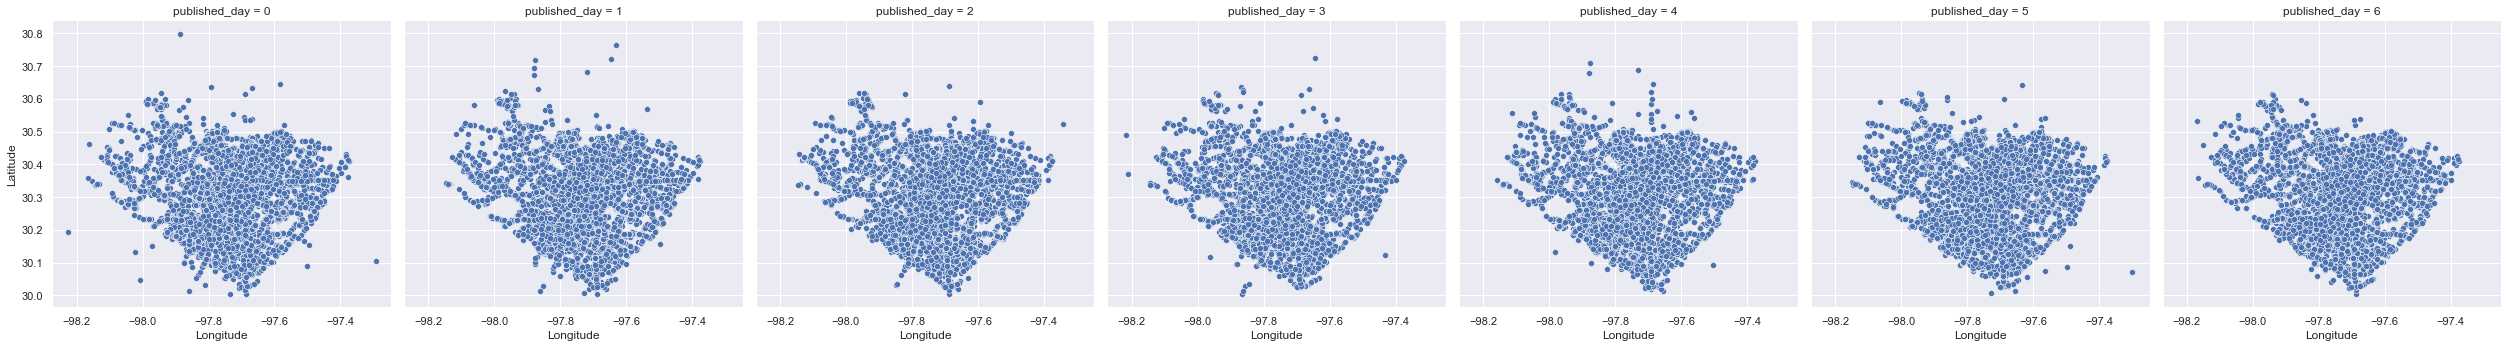

In [725]:
ax = sns.relplot(x='Longitude',y='Latitude', data=df, kind='scatter', col='published_day')

Breaking down published date into time blocks. I need to slice and isolate the times of day from the datetime object.

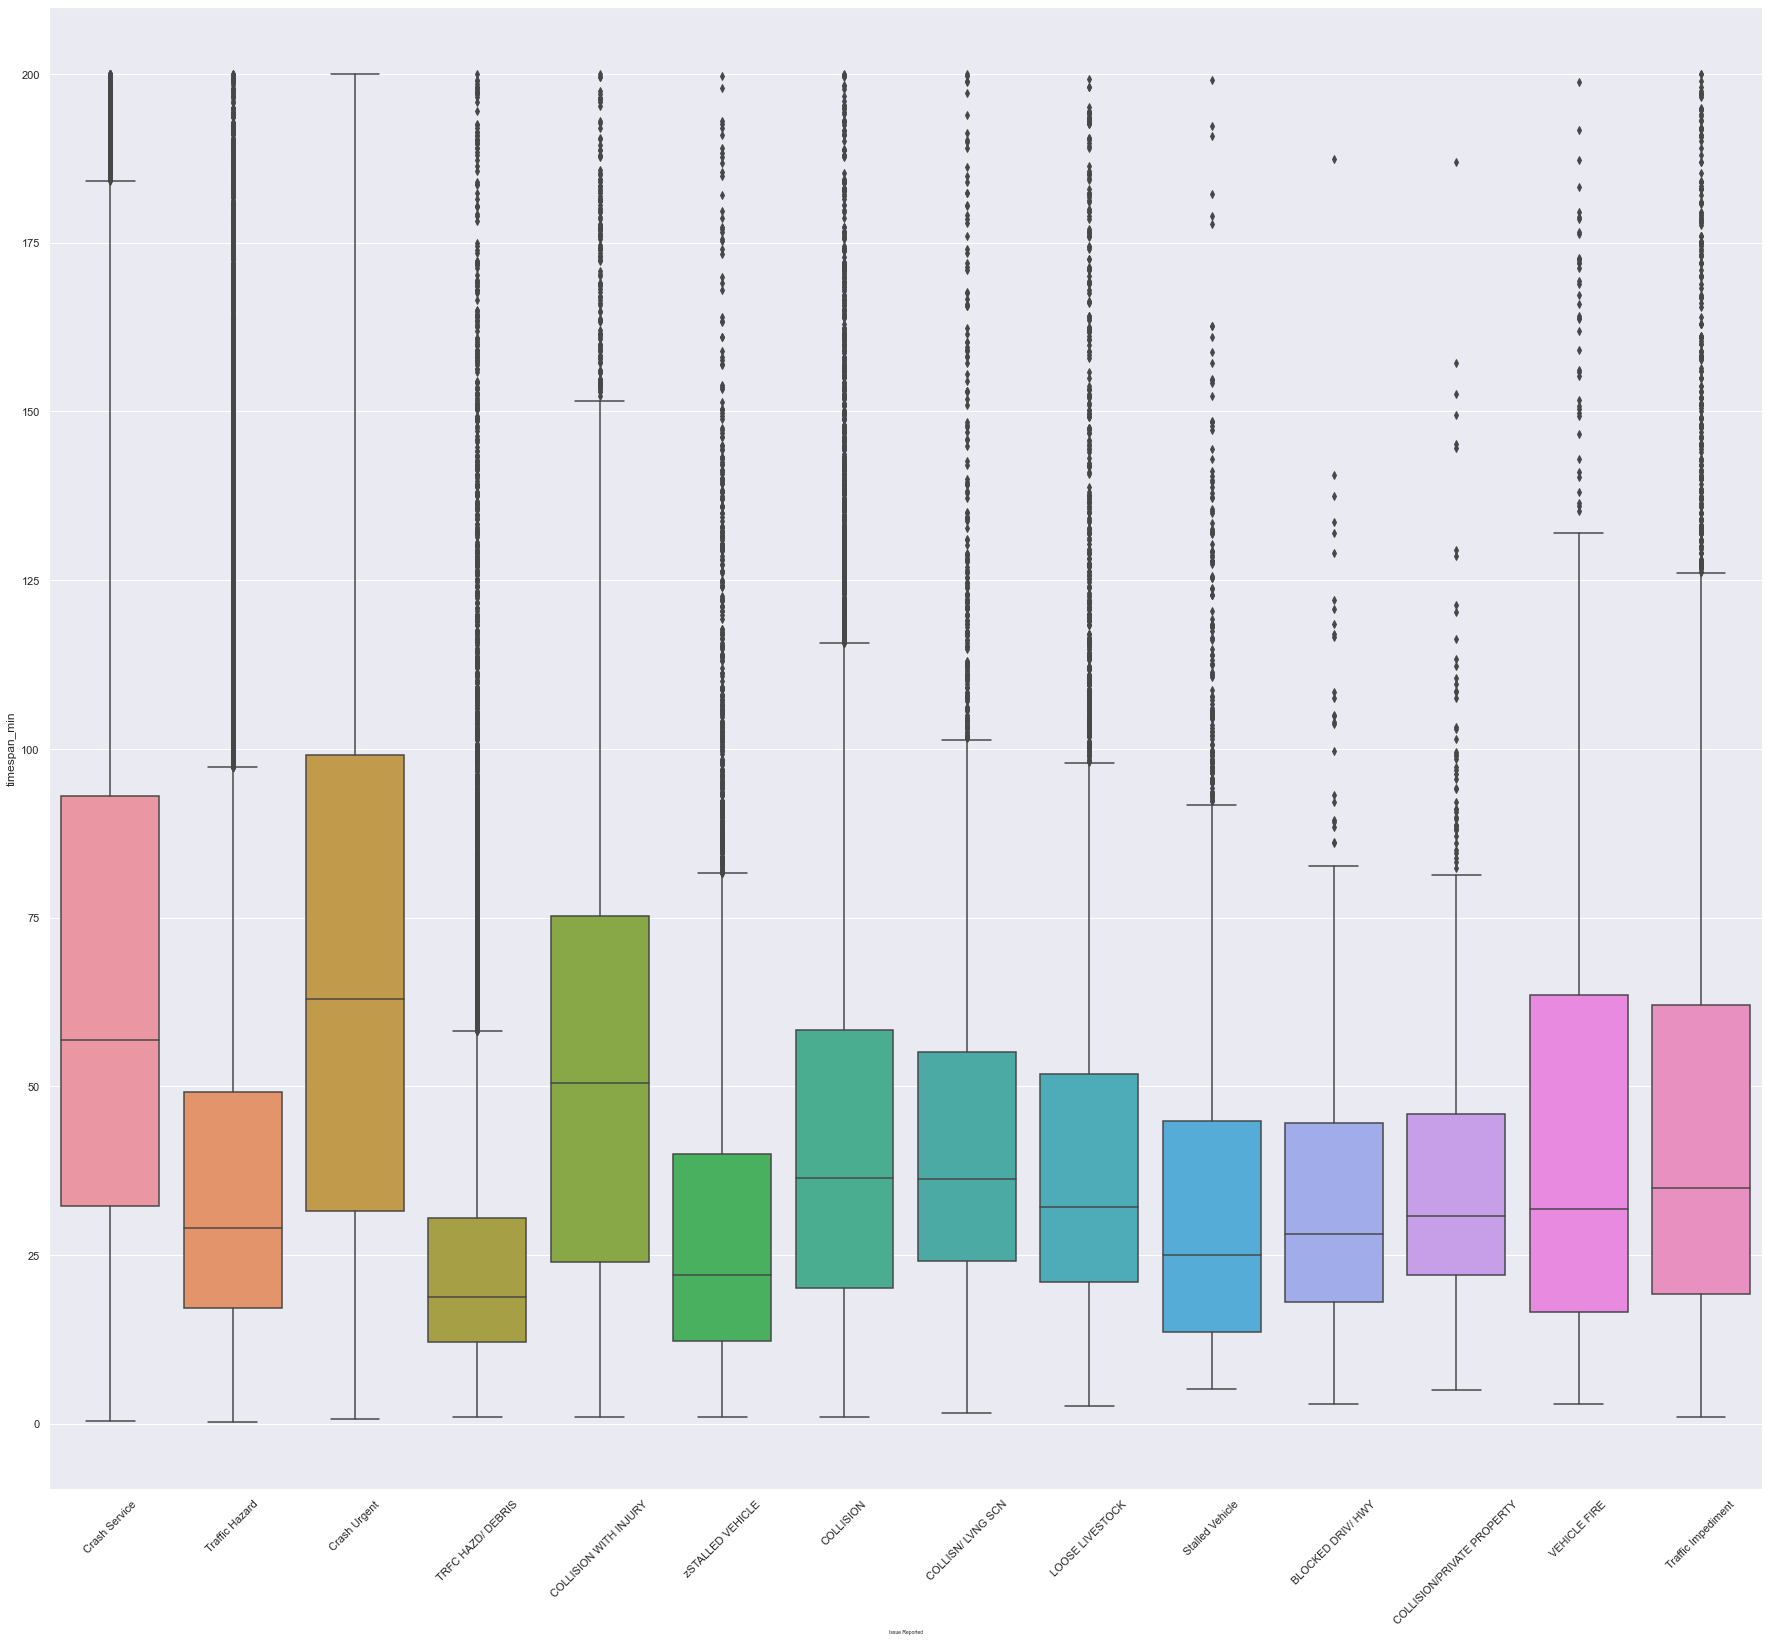

In [627]:

ax = sns.boxplot(x= 'issue_reported', y='timespan_min', data=df)
ax.set_xlabel('Issue Reported', fontsize=5)
ax.set_xticklabels(ax.get_xticklabels(),rotation=45)
sns.set(rc={'figure.figsize':(30.7,27.27)})




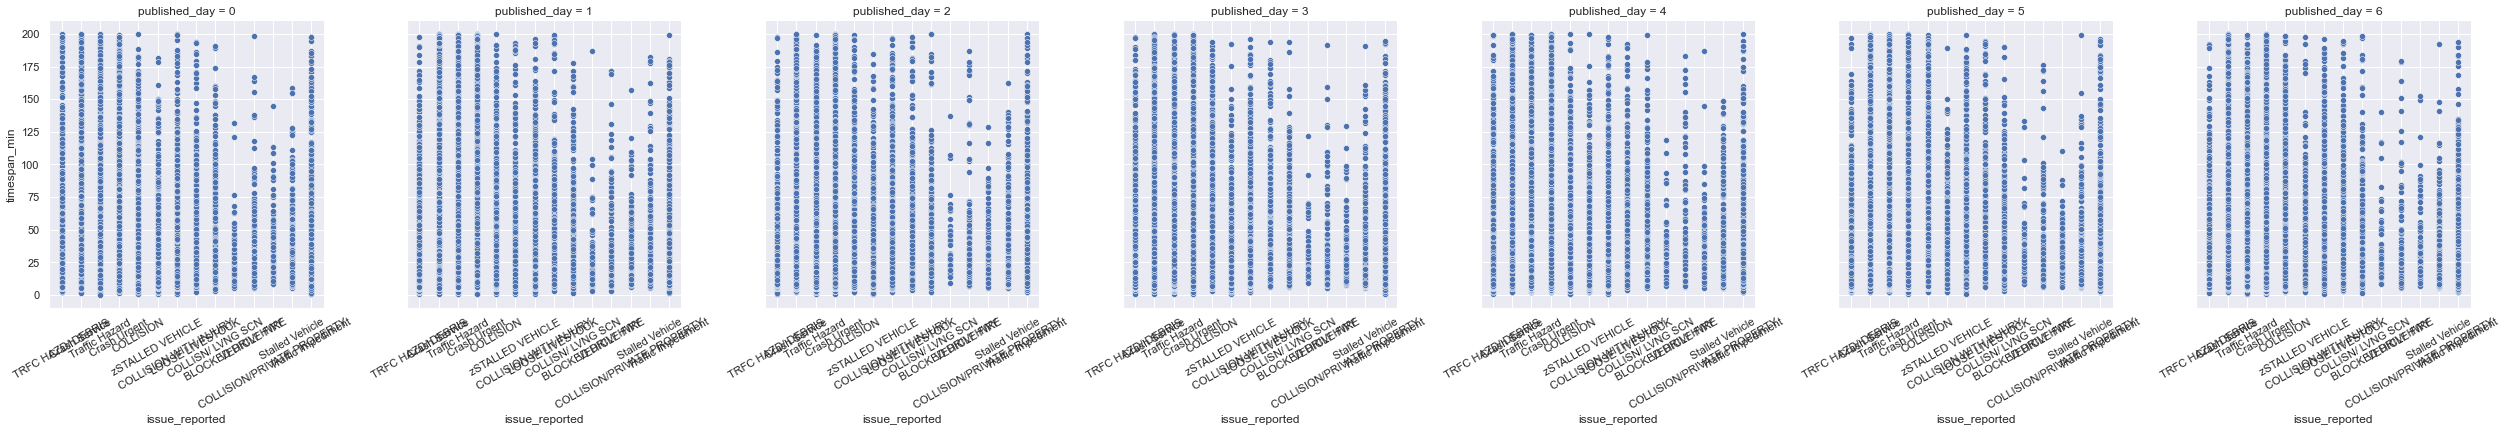

In [645]:
ax = sns.relplot(x= 'issue_reported', y='timespan_min', data=df, kind='scatter', col='published_day')
ax.set_xticklabels(rotation=30)

plt.show()

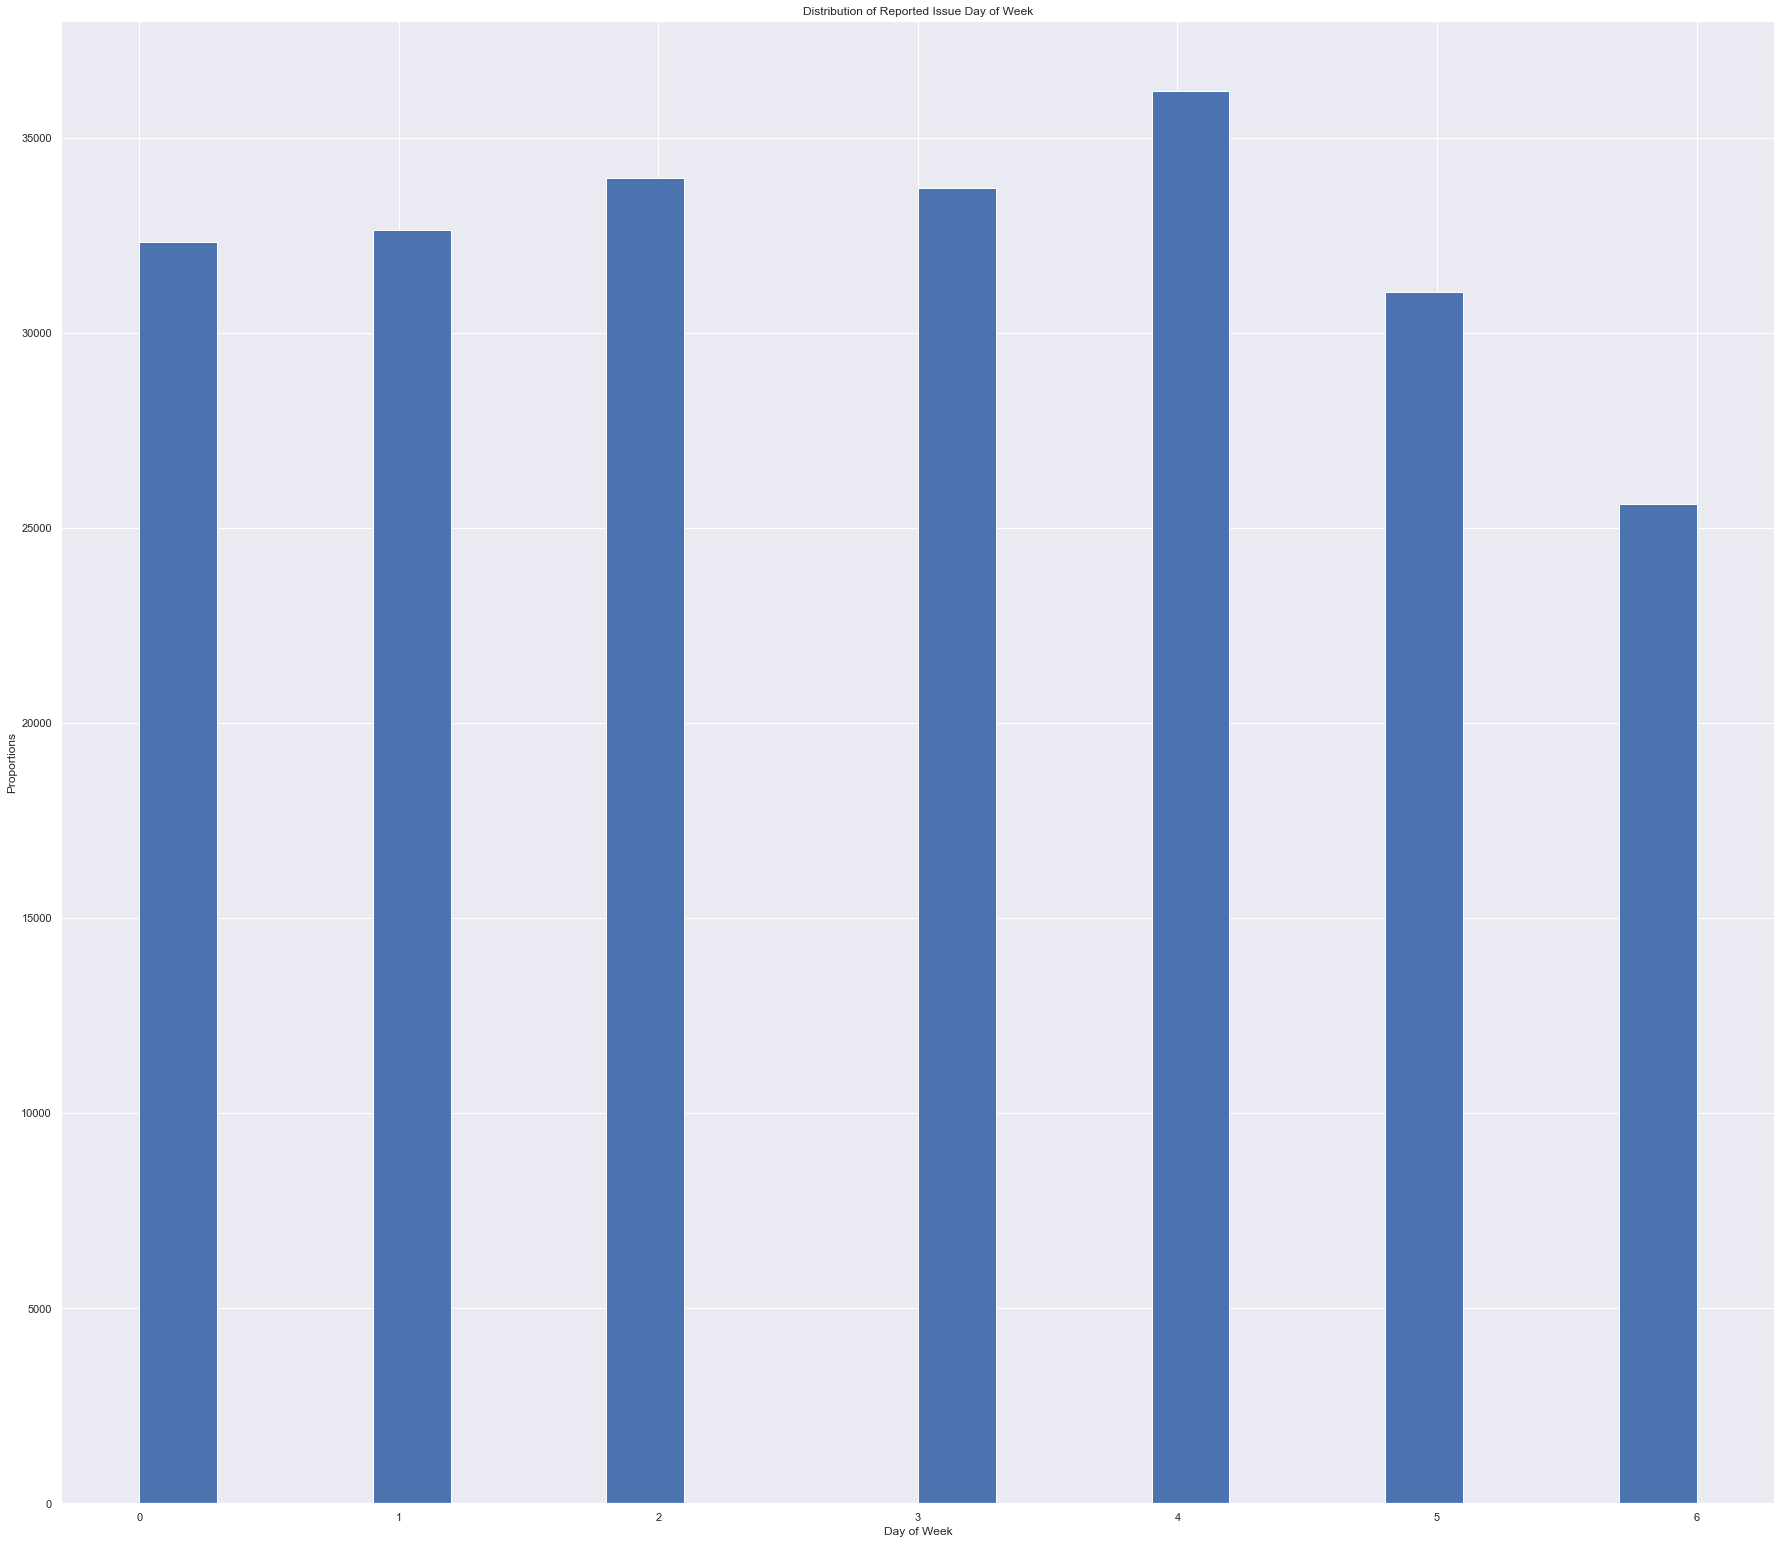

In [629]:
df.published_day.hist(bins=20)
plt.xlabel('Day of Week')
plt.ylabel('Proportions')
plt.title('Distribution of Reported Issue Day of Week');

##Plot Key 
- 0 = Monday  
- 1 = Tuesday
- 2 = Wednesday
- 3 = Thursday
- 4 = Friday
- 5 = Saturday
- 6 = Sunday


We can see that the highest instances of traffic incidents happen of Friday, which is to be expected due to a lively nightlife. Conversely, Sunday has the least amount of incidents as most people are resting and preparing for the work week.

Monday and Tuesday hold steady at around 35,0000
Wednesday and Thursday there is a slight increase to around 37,000
Saturday has less instances than weekdays at about 33,000

The next thing I need to do is take latitude and logitude and put them in a scatter plot over a map.

In [610]:
crs = {'init': 'epsg:4326'}

In [611]:
geometry = [Point(xy) for xy in zip(df['Longitude'], df['Latitude'])]
geometry[:3]

In [612]:
geo_df = gpd.GeoDataFrame(df,
                         crs = crs,
                         geometry = geometry)
geo_df.head()

/Users/tshields/opt/anaconda3/envs/Springboard/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


,short_ID,published_date,issue_reported,Latitude,Longitude,Address,status_date,issue_timespan,published_day,timespan_sec,timespan_min,geometry
0,C16,2018-06-13 06:35:59+00:00,Crash Service,30.283797,-97.741906,W 21ST ST & GUADALUPE ST,2018-06-13 09:00:03+00:00,0 days 02:24:04,2,8644.0,144.066667,POINT (-97.74191 30.28380)
1,6B2,2018-06-13 10:15:36+00:00,Traffic Hazard,30.339593,-97.700963,400-717 E ANDERSON LN EB,2018-06-13 11:20:03+00:00,0 days 01:04:27,2,3867.0,64.450000,POINT (-97.70096 30.33959)
2,2A7,2020-04-17 21:25:03+00:00,Crash Urgent,30.329455,-97.638105,E US 290 HWY SVRD EB & EASTERN HEIGHTS BLVD,2020-04-17 21:55:03+00:00,0 days 00:30:00,4,1800.0,30.000000,POINT (-97.63810 30.32945)
3,89D,2020-04-17 21:40:52+00:00,Traffic Hazard,30.202806,-97.760701,5300-blk S Ih 35 Sb,2020-04-17 21:55:03+00:00,0 days 00:14:11,4,851.0,14.183333,POINT (-97.76070 30.20281)
4,E7F,2020-04-17 21:00:55+00:00,Crash Urgent,30.184265,-97.687339,4500-4720 S Us 183 Hwy Sb,2020-04-17 23:30:04+00:00,0 days 02:29:09,4,8949.0,149.150000,POINT (-97.68734 30.18426)


import plotly.express as px
px.set_mapbox_access_token('pk.eyJ1IjoidG9tc2hpZWxkczcxIiwiYSI6ImNreXl0anNxajBjaXQybnJtdW5zeXdqb3UifQ.6vXBOrDTeliFVziQaB6ecg')
gpd['size']=65
#mapbox tokens found here https://account.mapbox.com/access-tokens
fig = px,scatter_mapbox(gdf, lat = gpd.geometry.y, lon=gpd.geometry.x, cmapbox_style='outdoors', size='size', zoom=10)
fig.show()

fig,ax =plt.subplots(figsize=(15,15))
street_map.plot(ax = ax, alpha = 0.4, color='grey')
geo_df[geo_df['WnvPresent'] ==0].plot(ax = ax, markersize = 20, color = 'blue',marker = '=o', label = 'Neg')
geo_df[geo_df['WnvPresent'] ==1].plot(ax = ax, markersize = 20, color = 'red',marker = '^', label = 'Pos')
plt.legend(prop={'size': 15})

In [ ]:
#spots = pd.DataFrame(df['Latitude','Longitude'])
#gdf = gpd.GeoDataFrame(df, geometry=gpd.df_from_xy(df.Latitude, df.Longitude))
#gdf